In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pickle
from tensorflow.keras.utils import to_categorical

# from sklearn.metrics import confusion_matrix
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.preprocessing import StandardScaler

# from tensorflow.keras.layers import LSTM, Dense, Dropout
# from tensorflow.keras.models import Sequential, load_model
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import CSVLogger
# import tensorflow as tf

In [ ]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import roc_auc_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Data Loading**

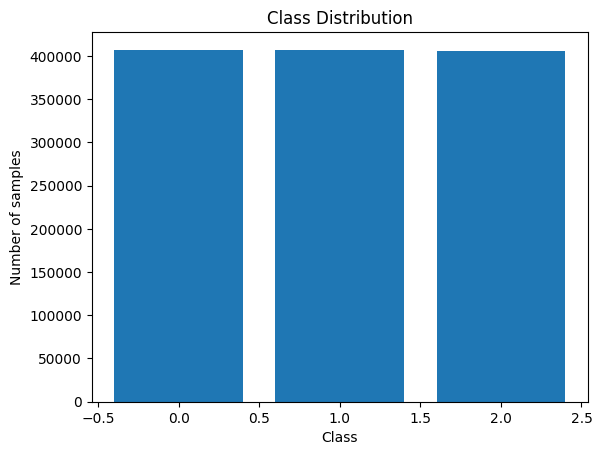

In [ ]:
Sampled_train = pd.read_csv("/content/drive/MyDrive/Dataset_RP/traincsv.csv")
Sampled_train = pd.concat([Sampled_train,pd.read_csv("/content/drive/MyDrive/Dataset_RP/train12csv.csv")])

class_distribution = Sampled_train['faultNumber'].value_counts()
# Plotting the class distribution
plt.bar(class_distribution.index, class_distribution.values)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Class Distribution')
plt.show()

train_data = pd.DataFrame()
val_data = pd.DataFrame()
test_data = pd.DataFrame()

for i in range (3):
  for j in range (1,3):
    Sample_temp = Sampled_train[Sampled_train['faultNumber']==i]
    Sample_temp = Sample_temp[Sample_temp['simulationRun']==j]
    begin = 0
    train_size = int(((len(Sample_temp)) * 0.6)/20)
    val_size = int(((len(Sample_temp) * 0.2)/20))
    test_size = int(((len(Sample_temp) * 0.2)/20))

    for k in range (1,21):
      train_data =pd.concat([train_data,Sample_temp[begin:begin+train_size]])
      val_data = pd.concat([val_data,Sample_temp[begin+train_size:begin+train_size+val_size]])
      test_data = pd.concat([test_data,Sample_temp[begin+train_size+val_size:begin+train_size+val_size+test_size]])
      begin = begin+train_size+val_size+test_size
Sampled_train = train_data
Sampled_cv = val_data
Sampled_test = test_data

In [ ]:
Sampled_cv

,faultNumber,simulationRun,sample,VelocityRef:1,<xdot>,<BattSoc>,<BattPwr>,<Cltch1State>,<Cltch2State>,<BattV>,...,<MotTrq>,<StartTrq>,StartCmd,MotTrqCmd,BattCrnt:1,MotPwrElec:1,MotPwrMech:1,IntkVlvLiftCmd,FuelMainSoi,FuelFlw
6113,0,1,28.635,8.829487,8.102444e+00,58.671195,0.000650,1,1,271.994282,...,0.000002,-1.450000e-62,0,0.000002,0.000002,0.000606,0.000513,0,0,0.001287
6114,0,1,28.640,8.835299,8.105543e+00,58.671195,0.000634,1,1,271.994282,...,0.000002,-1.150000e-62,0,0.000002,0.000002,0.000591,0.000500,0,0,0.001292
6115,0,1,28.645,8.841110,8.108663e+00,58.671195,0.000619,1,1,271.994282,...,0.000002,-8.730000e-63,0,0.000002,0.000002,0.000576,0.000488,0,0,0.001297
6116,0,1,28.650,8.846922,8.111804e+00,58.671195,0.000604,1,1,271.994282,...,0.000002,-1.290000e-62,0,0.000002,0.000002,0.000562,0.000476,0,0,0.001302
6117,0,1,28.655,8.852733,8.114965e+00,58.671195,0.000589,1,1,271.994282,...,0.000002,-1.040000e-62,0,0.000002,0.000002,0.000549,0.000465,0,0,0.001307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606614,2,2,989.780,3.937500,-1.130000e-22,0.292693,0.000000,0,0,210.619638,...,0.000000,0.000000e+00,0,0.000000,0.000000,0.000000,0.000000,0,0,0.000000
606615,2,2,989.785,3.942708,-1.130000e-22,0.292693,0.000000,0,0,210.619638,...,0.000000,0.000000e+00,0,0.000000,0.000000,0.000000,0.000000,0,0,0.000000
606616,2,2,989.790,3.947917,-1.130000e-22,0.292693,0.000000,0,0,210.619638,...,0.000000,0.000000e+00,0,0.000000,0.000000,0.000000,0.000000,0,0,0.000000
606617,2,2,989.795,3.953125,-1.130000e-22,0.292693,0.000000,0,0,210.619638,...,0.000000,0.000000e+00,0,0.000000,0.000000,0.000000,0.000000,0,0,0.000000


**Data Preprocessing**

In [ ]:
# Drop some mysterious fault type
Sampled_train.drop(Sampled_train[(Sampled_train.faultNumber == 3) | (Sampled_train.faultNumber == 9) | (Sampled_train.faultNumber == 15)].index, inplace = True)
Sampled_test.drop(Sampled_test[(Sampled_test.faultNumber == 3) | (Sampled_test.faultNumber == 9) | (Sampled_test.faultNumber == 15)].index, inplace = True)
Sampled_cv.drop(Sampled_cv[(Sampled_cv.faultNumber == 3) | (Sampled_cv.faultNumber == 9) | (Sampled_cv.faultNumber == 15)].index, inplace = True)

In [ ]:
# make the Y value usable in LSTM
y_train = to_categorical(Sampled_train['faultNumber'],num_classes=3)
y_test = to_categorical(Sampled_test['faultNumber'],num_classes=3)
y_cv = to_categorical(Sampled_cv['faultNumber'],num_classes=3)

In [ ]:
y_train[0]

array([1., 0., 0.], dtype=float32)

In [ ]:
# drop unused meta data from x
x_train_df = Sampled_train.drop(['faultNumber','simulationRun','sample'],axis=1)
x_test_df = Sampled_test.drop(['faultNumber','simulationRun','sample'],axis =1)
x_cv_df = Sampled_cv.drop(['faultNumber','simulationRun','sample'],axis =1)

In [ ]:
x_test_df

,VelocityRef:1,<xdot>,<BattSoc>,<BattPwr>,<Cltch1State>,<Cltch2State>,<BattV>,<TransGear>,<EngSpd>,<IntkVlvLift>,...,<MotTrq>,<StartTrq>,StartCmd,MotTrqCmd,BattCrnt:1,MotPwrElec:1,MotPwrMech:1,IntkVlvLiftCmd,FuelMainSoi,FuelFlw
8150,7.078655,7.281186e+00,58.933057,-6862.252524,1,1,273.657197,3,1261.435448,0,...,-61.501718,-4.600000e-81,0,-61.362940,-25.076090,-6987.188751,-8118.924267,0,0,0.0
8151,7.073961,7.276460e+00,58.933714,-6854.915682,1,1,273.655901,3,1260.615778,0,...,-61.477637,-3.530000e-81,0,-61.344655,-25.049398,-6979.975202,-8110.469040,0,0,0.0
8152,7.069267,7.271735e+00,58.934370,-6847.710085,1,1,273.654633,3,1259.796223,0,...,-61.454618,-2.810000e-81,0,-61.328105,-25.023183,-6972.887253,-8102.158625,0,0,0.0
8153,7.064573,7.267012e+00,58.935025,-6840.632411,1,1,273.653394,3,1258.976775,0,...,-61.432637,-2.310000e-81,0,-61.311556,-24.997433,-6965.920533,-8093.989558,0,0,0.0
8154,7.059879,7.262290e+00,58.935680,-6833.679636,1,1,273.652182,3,1258.157429,0,...,-61.411653,-1.760000e-81,0,-61.296606,-24.972136,-6959.070701,-8085.956139,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608637,2.587500,-9.430000e-23,0.292693,0.000000,0,0,210.619638,1,-0.188301,0,...,0.000000,0.000000e+00,0,0.000000,0.000000,0.000000,0.000000,0,0,0.0
608638,2.583333,-9.430000e-23,0.292693,0.000000,0,0,210.619638,1,-0.188287,0,...,0.000000,0.000000e+00,0,0.000000,0.000000,0.000000,0.000000,0,0,0.0
608639,2.579167,-9.430000e-23,0.292693,0.000000,0,0,210.619638,1,-0.188273,0,...,0.000000,0.000000e+00,0,0.000000,0.000000,0.000000,0.000000,0,0,0.0
608640,2.575000,-9.430000e-23,0.292693,0.000000,0,0,210.619638,1,-0.188259,0,...,0.000000,0.000000e+00,0,0.000000,0.000000,0.000000,0.000000,0,0,0.0


**Parameters**

In [ ]:
cost_false_positive = 2
cost_false_negative = 16

sensors = ['<EngSpd>',
 'FuelFlw',
 '<EngTrq>',
 '<ThrPosPct>',
 '<Acc>',
 'VelocityRef:1',
 '<BattSoc>',
 '<xdot>',
 '<WgAreaPct>',
 '<BattPwr>']
model_path = '/content/drive/MyDrive/models/' + '0_' + "none/"
# get prior probability
temp = Sampled_train['faultNumber'].value_counts()
non_fault = temp[0]
total = temp.sum()

temp = Sampled_cv['faultNumber'].value_counts()
non_fault += temp[0]
total += temp.sum()

P_present = non_fault/total
P_absent = 1 - P_present

**Utility Functions**

In [ ]:
def feature_remover(features_names):
    # remove a list of features from x

    dimension = dict()

    # row dimension
    dimension['train_row'] = len(x_train_df)
    dimension['test_row'] = len(x_test_df)
    dimension['cv_row'] = len(x_cv_df)

    # create a copy so we don't change the original dataframe
    x_train_masked_df = x_train_df.copy()
    x_test_masked_df = x_test_df.copy()
    x_cv_masked_df = x_cv_df.copy()

    for feature in features_names:
        x_train_masked_df.drop([feature], axis = 1, inplace = True)
        x_test_masked_df.drop([feature], axis = 1, inplace = True)
        x_cv_masked_df.drop([feature], axis = 1, inplace = True)

    # column dimension
    dimension['train_col'] = x_train_masked_df.shape[1]
    dimension['test_col'] = x_test_masked_df.shape[1]
    dimension['cv_col'] = x_cv_masked_df.shape[1]

    standard_scalar = StandardScaler()
    x_train_masked_df = standard_scalar.fit_transform(x_train_masked_df)
    x_test_masked_df = standard_scalar.transform(x_test_masked_df)
    x_cv_masked_df = standard_scalar.transform(x_cv_masked_df)


    x_train = np.resize(x_train_masked_df, (dimension['train_row'], dimension['train_col'], 1))
    x_test = np.resize(x_test_masked_df, (dimension['test_row'], dimension['test_col'], 1))
    x_cv = np.resize(x_cv_masked_df, (dimension['cv_row'], dimension['cv_col'], 1))

    return dimension, x_train, x_test, x_cv

In [ ]:
# helper function to calculate probability of correctly giving signal when present
def get_signal_present(prediction, ground_truth):
    present_index = list()
    for i in range(len(ground_truth)):
        if ground_truth[i] == 0:
            present_index.append(i)

    counter = 0
    for index in present_index:
        if prediction[index] == 0:
            counter += 1

    return counter/len(present_index)

# helper function to calculate probability of correctly giving signal when present
# there should be a more generic way using operator module to merge this with the one above.
def get_no_signal_absent(prediction, ground_truth):
    absent_index = list()
    for i in range(len(ground_truth)):
        if ground_truth[i] != 0:
            absent_index.append(i)

    counter = 0
    for index in absent_index:
        if prediction[index] != 0:
            counter += 1
    return counter/len(absent_index)

In [ ]:
def get_expected_cost(prediction):
  # get P(signal|present) and P(no signal|absent)
    cost_false_negative=4
    ground_truth = Sampled_test['faultNumber'].tolist()
    P_signal_present = get_signal_present(prediction, ground_truth)
    P_no_signal_absent = get_no_signal_absent(prediction, ground_truth)
    P_signal_absent = 1 - P_no_signal_absent
    P_no_signal_present = 1 - P_signal_present
    print("P_signal_present"+str(P_signal_present))
    print("P_no_signal_absent"+str(P_no_signal_absent))
  # get P(signal)
    P_signal = P_present * P_signal_present + P_absent * P_signal_absent
    P_no_signal = 1 - P_signal
    print("P_signal"+str(P_signal))
  # bayesian probability
    P_absent_signal = (P_signal_absent * P_absent) / P_signal
    P_present_signal = (P_signal_present * P_present) / P_signal
    P_absent_no_signal = (P_no_signal_absent * P_absent) / P_no_signal
    P_present_no_signal = (P_no_signal_present * P_present) / P_no_signal
    print("P_absent_signal"+str(P_absent_signal))
    print("P_present_signal"+str(P_present_signal))
    print("P_absent_no_signal"+str(P_absent_no_signal))
    print("P_present_no_signal"+str(P_present_no_signal))
  # calculate the evoi

    print(min(cost_false_positive * P_absent_signal, cost_false_negative * P_present_signal))
    print(min(cost_false_positive * P_absent_no_signal, cost_false_negative * P_present_no_signal))
    print(P_signal * min(cost_false_positive * P_absent_signal, cost_false_negative * P_present_signal))
    print(P_no_signal * min(cost_false_positive * P_absent_no_signal, cost_false_negative * P_present_no_signal))
    evoi = P_signal * min(cost_false_positive * P_absent_signal, cost_false_negative * P_present_signal) + P_no_signal * min(cost_false_positive * P_absent_no_signal, cost_false_negative * P_present_no_signal)

    return evoi

In [ ]:
def plot_dict(dictionary):
    x, y = [], []
    for key, value in dictionary.items():
        x.append(key)
        y.append(value)
    return x, y

**Lower Branch**

In [ ]:
# prepare the data
dimension, x_train, x_test, x_cv = feature_remover(features_names = sensors)

In [ ]:
# load the model
base_42_model = load_model(model_path + 'base', compile = False)
base_42_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 22, 256)           264192    
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 300)               38700     
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               38528     
                                                                 
 dense_2 (Dense)             (None, 3)                 387       
                                                                 
Total params: 538,927
Trainable params: 538,927
Non-trai

In [ ]:
# get prediction from the base model
base_prediction = base_42_model.predict(x_test, verbose = 1)
base_prediction = np.argmax(base_prediction, axis=-1)

7615/7615 [==============================] - 27s 3ms/step


In [ ]:
base_cost = get_expected_cost(base_prediction)
base_cost

P_signal_present0.5987346437346437
P_no_signal_absent0.8999260446197461
P_signal0.2666625172372479
P_absent_signal0.2499115810555581
P_present_signal0.750088418944442
P_absent_no_signal0.8172035196667641
P_present_no_signal0.18279648033323598
0.4998231621111162
0.7311859213329439
0.13328410258203127
0.5362060429818648


0.6694901455638961

**Upper Branch**

In [ ]:
upper_dict = dict()
for sensor in sensors:
    remove_sensors = sensors.copy()
    remove_sensors.remove(sensor)
    dimension, x_train, x_test, x_cv = feature_remover(features_names = remove_sensors)
    print(sensor)
    upper_model = load_model(model_path + '+' + sensor, compile= False)
    upper_prediction = upper_model.predict(x_test, verbose = 1)
    upper_prediction = np.argmax(upper_prediction, axis=-1)
    upper_dict[sensor] = get_expected_cost(upper_prediction)
    print(upper_dict[sensor])

<EngSpd>
4493/7615 [================>.............] - ETA: 8s

KeyboardInterrupt: ignored

In [ ]:
upper_dict

**EVOI**

In [ ]:
# Calculate the evoi
evoi_dict = dict()
for sensor in sensors:
    evoi_dict[sensor] = base_cost - upper_dict[sensor]
evoi_dict

In [ ]:
sorted(evoi_dict.items(), key=lambda x: x[1], reverse= True)

In [ ]:
x_1, y_1 = plot_dict(evoi_dict)
#y_1_100 = [z * 100 for z in y_1]
plt.figure(figsize=(20,10))
sns.barplot(x=x_1,y= y_1, palette = mpl.cm.ScalarMappable(cmap=sns.dark_palette("#69d", reverse=False, as_cmap=True)).to_rgba(y_1))
#plt.xticks(rotation=45);
#plt.ylim((-5.0, 16.0))
plt.title('Complete Feature Validation Accuracy Advantage')
plt.ylabel('%')
plt.xlabel('Masked Feature Name');

#AUROC calculation (for comparison)

In [ ]:
sensor_list=[]
for t in sorted(evoi_dict.items(), key=lambda x: x[1], reverse= True):
  sensor_list.append(t[1])
sensor_list

In [ ]:
x_train_df = x_train_df.filter(sensor_list, axis=1)
x_test_df=x_test_df.filter(sensor_list, axis=1)
x_test_df=x_cv_df.filter(sensor_list, axis=1)

In [ ]:
def x_generator(masked, feature_name):
    # generate the needed x matrix for training, while keeping x_df intact

    dimension = dict()

    # row dimension
    dimension['train_row'] = len(x_train_df)
    dimension['test_row'] = len(x_test_df)
    dimension['cv_row'] = len(x_cv_df)

    # decide whether to mask a feature or not
    if masked == True:
        x_train_masked_df = x_train_df.drop([feature_name], axis = 1)
        x_test_masked_df = x_test_df.drop([feature_name], axis = 1)
        x_cv_masked_df = x_cv_df.drop([feature_name], axis = 1)
    else:
        x_train_masked_df = x_train_df.copy()
        x_test_masked_df = x_test_df.copy()
        x_cv_masked_df = x_cv_df.copy()

    # column dimension
    dimension['train_col'] = x_train_masked_df.shape[1]
    dimension['test_col'] = x_test_masked_df.shape[1]
    dimension['cv_col'] = x_cv_masked_df.shape[1]

    standard_scalar = StandardScaler()
    x_train_masked_df = standard_scalar.fit_transform(x_train_masked_df)
    x_test_masked_df = standard_scalar.transform(x_test_masked_df)
    x_cv_masked_df = standard_scalar.transform(x_cv_masked_df)

    x_train = np.resize(x_train_masked_df, (dimension['train_row'], dimension['train_col'], 1))
    x_test = np.resize(x_test_masked_df, (dimension['test_row'], dimension['test_col'], 1))
    x_cv = np.resize(x_cv_masked_df, (dimension['cv_row'], dimension['cv_col'], 1))

    return dimension, x_train, x_test, x_cv

In [ ]:
def train_model(x_train, y_train, x_cv, y_cv, train_col, feature_name):
    model = Sequential()
    model.add(LSTM(256,input_shape= (train_col, 1),return_sequences= True))
    model.add(LSTM(128,return_sequences= False))
    model.add(Dense(300))
    model.add(Dropout(0.5))
    model.add(Dense(128))
    model.add(Dense(3,activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # training
    model.fit(x_train, y_train, epochs = 15, verbose=2,batch_size=256,validation_data = (x_cv, y_cv))

    # saving the model
    model.save('/content/drive/MyDrive/models/'+ feature_name)

    # saving the history
    model_paras = model.history
    with open('/content/drive/MyDrive/models/' + feature_name + '/history.pickle', 'wb') as handle:
        pickle.dump(model_paras.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return model

In [ ]:
dimension, x_train, x_test, x_cv = x_generator(masked = False, feature_name=None)

feature_name = 'selected'
selected_model = train_model(x_train, y_train, x_cv, y_cv, dimension['train_col'], feature_name)

In [ ]:
# load the history of the current model
with open('/content/drive/MyDrive/models/' + feature_name + '/history.pickle', "rb") as hisotry_file:
    history = pickle.load(hisotry_file)

In [ ]:
score, acc = selected_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy:', acc)
print("Test loss:", score)
y_pred = selected_model.predict(x_test)
auc=selected_model.evaluate(x_test, y_test, verbose=0)[1]

In [ ]:
# Calculate the AUROC score
auroc = roc_auc_score(y_test, y_pred)
print("AUROC Score:", auroc)

In [ ]:
complete_peak = max(history['val_accuracy'])
print(complete_peak)